
# **<center><font style="color:rgb(205,100,154)">Human Action Recognition in Videos using Keras (CNN + LSTM)</font> </center>**


## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Visualize the Data with its Labels**

- **`Step 2:` Preprocess the Dataset**

- **`Step 3:` Split the Data into Train and Test Set**

- **`Step 4:` Implement the ConvLSTM Approach**

    - **`Step 4.1:` Construct the Model**
    
    - **`Step 4.2:` Compile & Train the Model**
    
    - **`Step 4.3:` Plot Model’s Loss & Accuracy Curves**
    
    - **`Step 4.3:` Plot Model’s Confusion Matrix**

- **`Step 5:` implement the LRCN Approach**
 
    - **`Step 5.1:` Construct the Model**
    
    - **`Step 5.2:` Compile & Train the Model**
    
    - **`Step 5.3:` Plot Model’s Loss & Accuracy Curves**
    
    - **`Step 5.3:` Plot Model’s Confusion Matrix**
    
- **`Step 6:` Test the Best Performing Model on YouTube videos**

Alright, so without further ado, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

I will start by installing and importing the required libraries.

In [1]:
# Discard the output of this cell.
#%%capture

#!pip install pytube rarfile --quiet --upgrade
#!pip install numpy opencv-python scikit-learn matplotlib --quiet
#!pip install seaborn

In [2]:
# Import the required libraries.
import os
import ssl
from urllib.request import urlretrieve
import rarfile
import math
import time
import random
import numpy as np
import datetime as dt
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

import cv2
from pytube import YouTube
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, MaxPooling3D, MaxPooling2D, LSTM, TimeDistributed, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from urllib.request import urlretrieve
from pytube import YouTube
from IPython.display import Video

### **<font style="color:rgb(134,19,348)">Setting up TensorFlow to use a GPU if one is available.</font>**

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### **<font style="color:rgb(134,19,348)">Downloading Dataset</font>**

Downloading the dataset into the data directory

In [5]:
DATA_URL = 'https://www.crcv.ucf.edu/data/UCF50.rar'
DATA_PATH = 'C:/Human Activity Recognition'
UCF50_DATA_PATH = os.path.join(DATA_PATH, 'UCF50')

if os.path.exists(DATA_PATH):
    print('[INFO] Data already exists.')
else:
    print('[INFO] Downloading data in the data directory.')
    os.mkdir(DATA_PATH)
    ssl._create_default_https_context = ssl._create_unverified_context
    urlretrieve(url=DATA_URL, filename=os.path.join(DATA_PATH, 'UCF50.rar'))

[INFO] Data already exists.


In [6]:
if os.path.exists(UCF50_DATA_PATH):
    print('[INFO] UCF50 Data already exists, skipping extraction process.')
else:
    print(f'[INFO] Extracting data: "{UCF50_DATA_PATH}"')
    r = rarfile.RarFile('data/UCF50.rar')
    r.extractall(DATA_PATH)
    r.close()

[INFO] UCF50 Data already exists, skipping extraction process.


In [7]:
# Details on the downloaded data
for dirpath, dirnames, filenames in os.walk(UCF50_DATA_PATH):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}".')

There are 50 directories and 0 files in "C:/Human Activity Recognition\UCF50".
There are 0 directories and 120 files in "C:/Human Activity Recognition\UCF50\BaseballPitch".
There are 0 directories and 107 files in "C:/Human Activity Recognition\UCF50\Basketball".
There are 0 directories and 130 files in "C:/Human Activity Recognition\UCF50\BenchPress".
There are 0 directories and 115 files in "C:/Human Activity Recognition\UCF50\Biking".
There are 0 directories and 120 files in "C:/Human Activity Recognition\UCF50\Billiards".
There are 0 directories and 71 files in "C:/Human Activity Recognition\UCF50\BreastStroke".
There are 0 directories and 82 files in "C:/Human Activity Recognition\UCF50\CleanAndJerk".
There are 0 directories and 123 files in "C:/Human Activity Recognition\UCF50\Diving".
There are 0 directories and 131 files in "C:/Human Activity Recognition\UCF50\Drumming".
There are 0 directories and 81 files in "C:/Human Activity Recognition\UCF50\Fencing".
There are 0 directori

## **<font style="color:rgb(134,19,348)">Step 1: Visualize the Data with its Labels</font>**

In the first step, I will visualize the data along with labels to get an idea about what I will be dealing with. I will be using the [UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:

*   **`50`** Action Categories

*   **`25`** Groups of Videos per Action Category

*   **`133`** Average Videos per Action Category

*   **`199`** Average Number of Frames per Video

*   **`320`** Average Frames Width per Video

*   **`240`** Average Frames Height per Video

*   **`26`** Average Frames Per Seconds per Video

For visualization, I will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']
['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing']


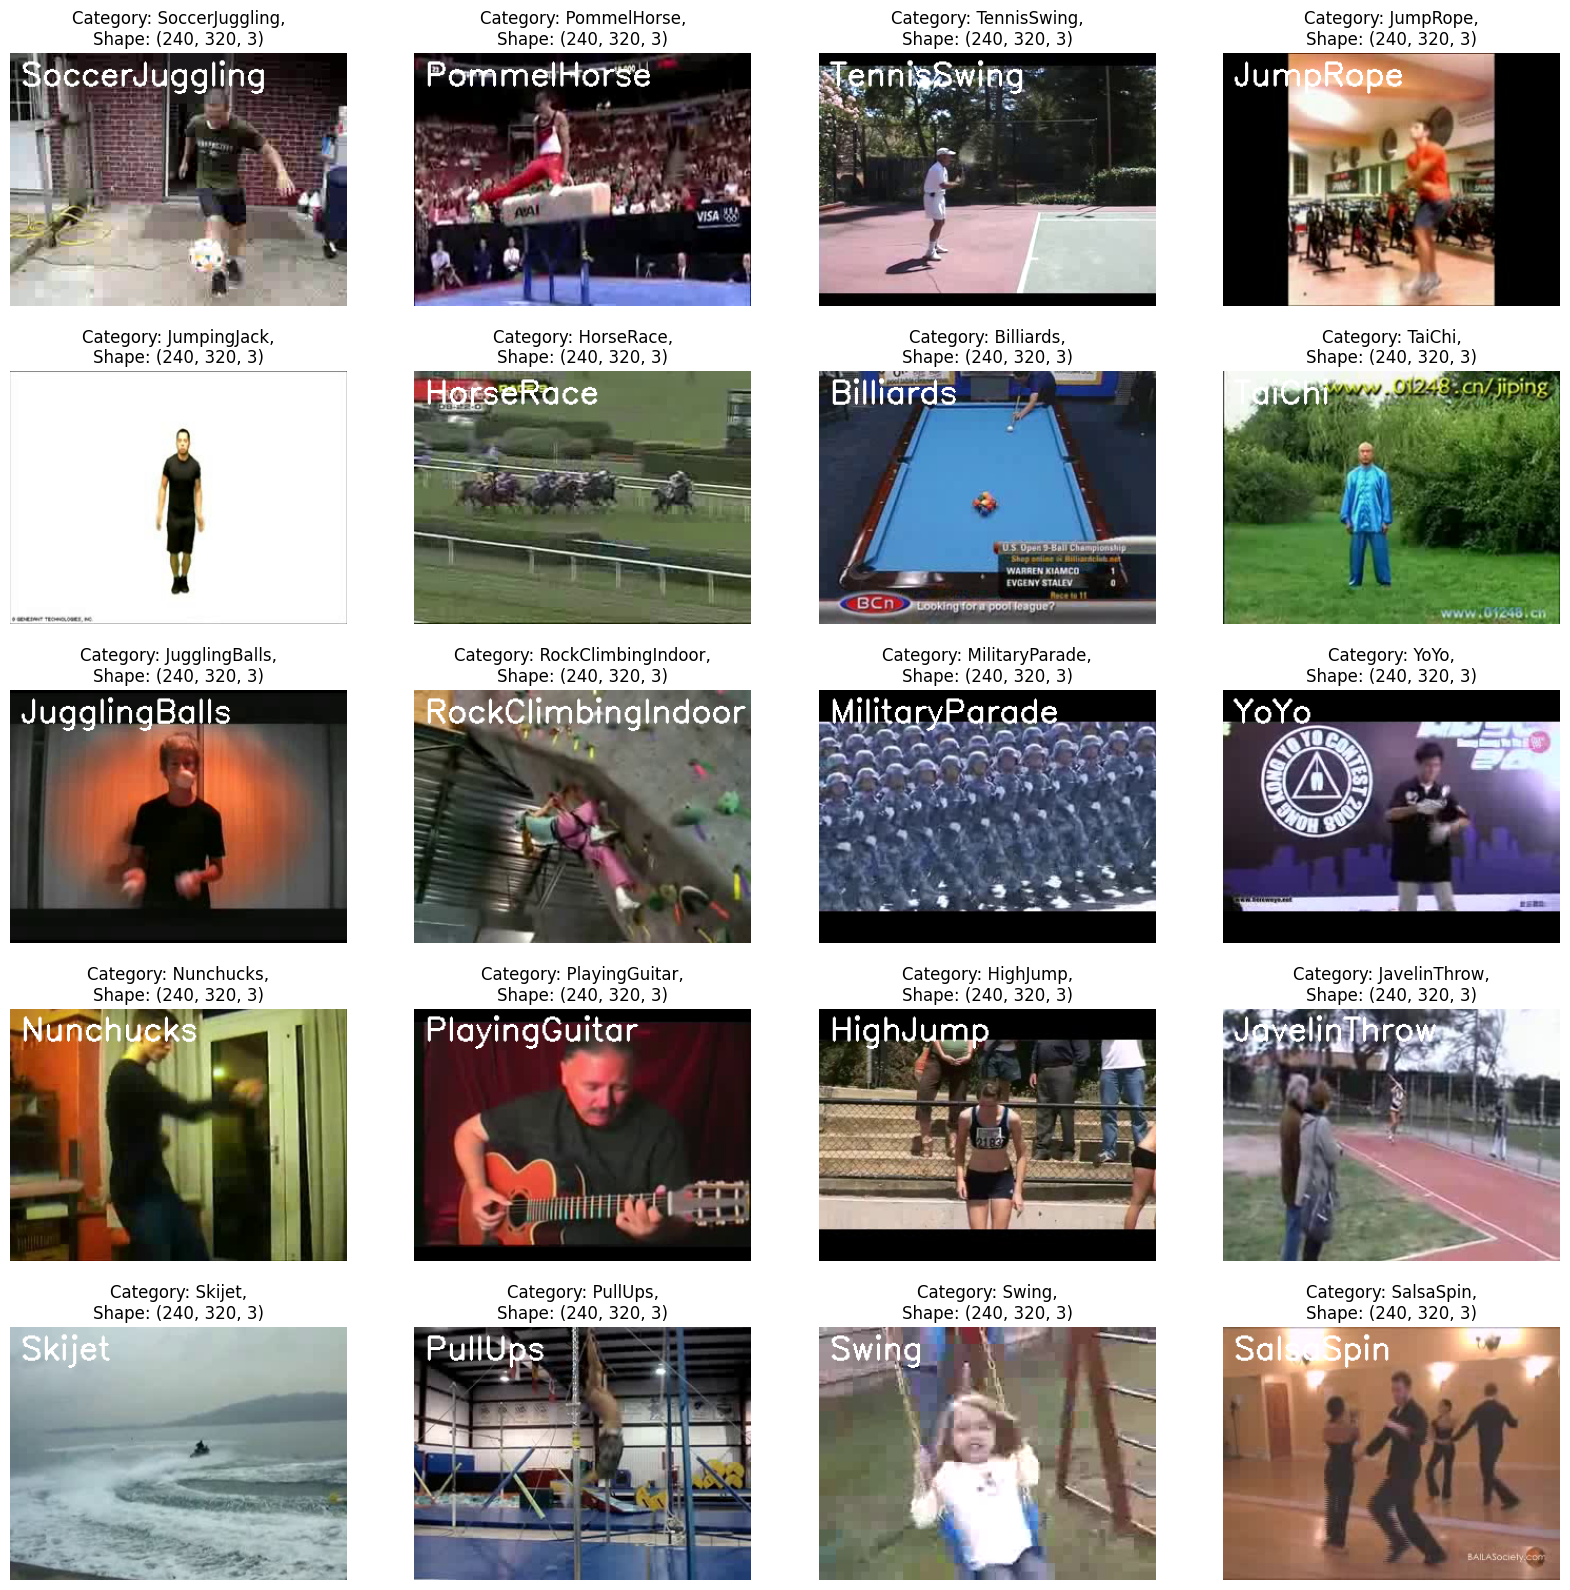

In [8]:
UCF50_DATA_PATH = "C:/Human Activity Recognition/UCF50/"  # Replace with the actual path to UCF50 dataset

plt.figure(figsize=(20, 20))  # Create a figure with a size of 20x20

all_classes_names = sorted(os.listdir(UCF50_DATA_PATH))  # Get a sorted list of class names in UCF50 dataset
print(all_classes_names)

# count  = 0
# lst = []
# for i in all_classes_names:
#     if(count < 10):
#         lst.append(i)
#         count = count + 1
#     if(count >= 10):
#         break

# print(lst)

random_range = random.sample(range(len(all_classes_names )), 20)  # Select 20 random categories for visualization

for i, rand_i in enumerate(random_range, 1):  # Iterate over the selected random categories
    class_name = all_classes_names [rand_i]  # Get the class name for the current category

    video_files_list = os.listdir(os.path.join(UCF50_DATA_PATH, class_name))  # Get the list of video files in the current category
    video_file_name = random.choice(video_files_list)  # Select a video file randomly from the current category

    video_reader = cv2.VideoCapture(os.path.join(UCF50_DATA_PATH, class_name, video_file_name))  # Read the video file
    _, frame = video_reader.read()  # Extract the first frame of the video
    video_reader.release()  # Release the video file

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert the frame from BGR to RGB format

    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)  # Add class name as text overlay

    plt.subplot(5, 4, i)  # Create a subplot with 5 rows and 4 columns
    plt.title(f'Category: {class_name},\nShape: {rgb_frame.shape}')  # Set the subplot title for category and shape information
    plt.imshow(rgb_frame)  # Display the frame in the subplot
    plt.axis(False)  # Disable axis

plt.show()  # Show the figure with all the subplots


## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, I will perform some preprocessing on the dataset. First, I will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [9]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "C:/Human Activity Recognition/UCF50/"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing']


**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

I will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as I will only need an evenly distributed sequence length of frames. 

Now lets extract frames or images from that video and transform the size and normalize the images, while extracting the frames I will not be collecting all the images.

Images will be collected at a interval and max images will be as per the sequence length we have set.

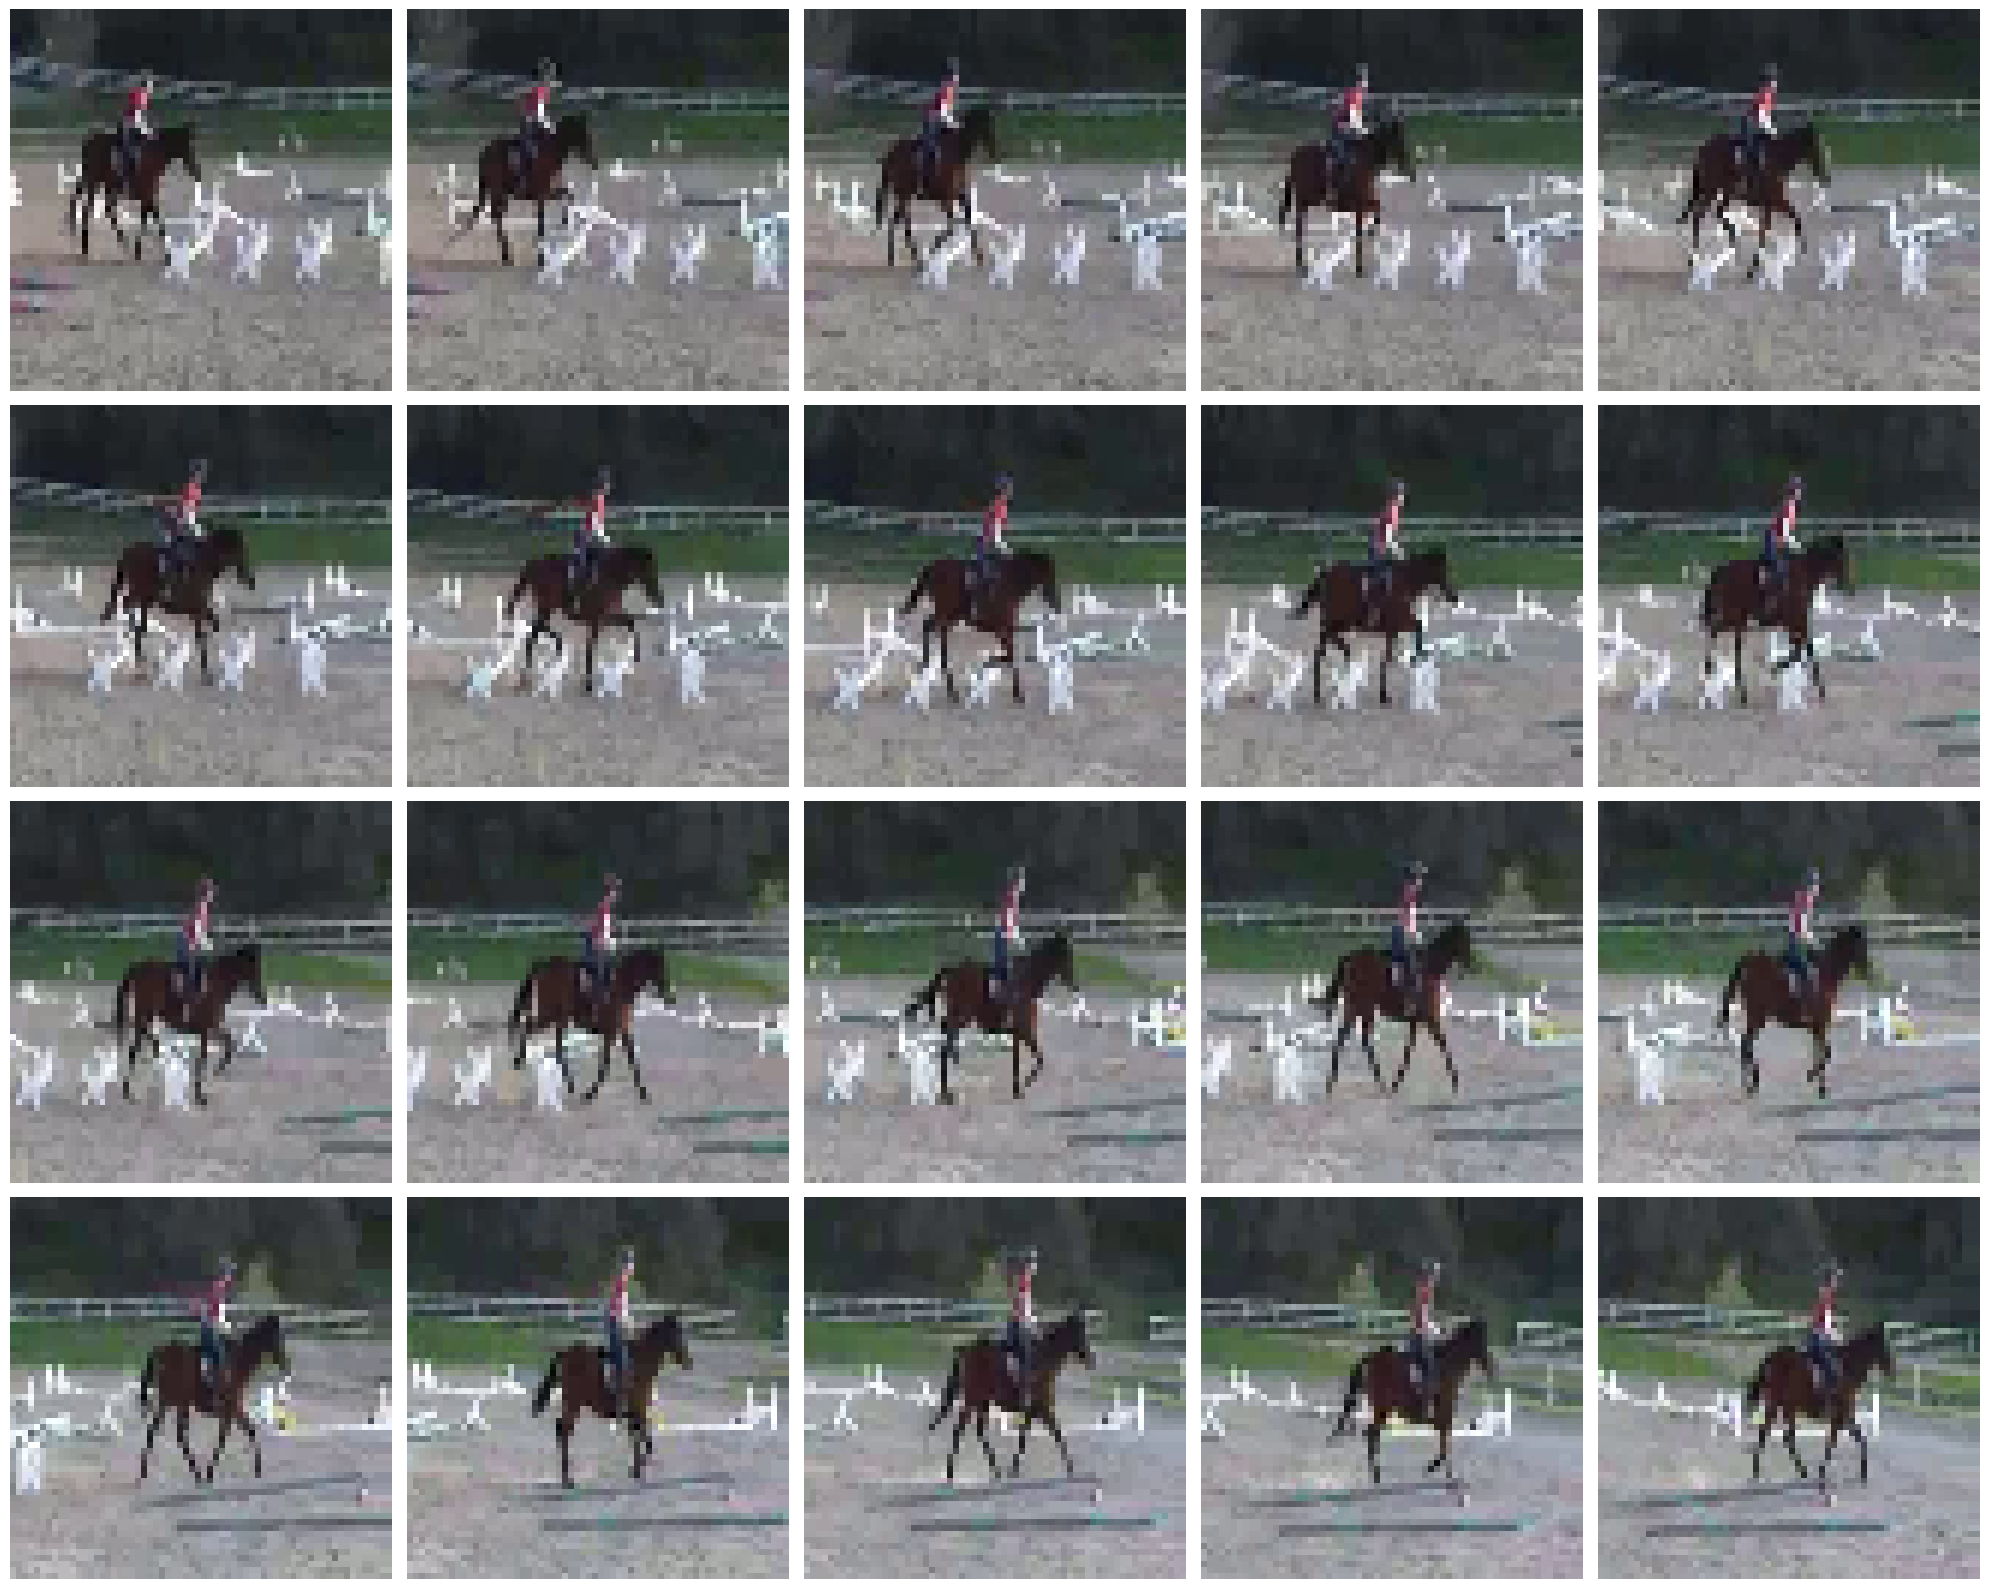

In [10]:
frames_list = []
video_reader = cv2.VideoCapture('C:/Human Activity Recognition/UCF50/HorseRiding/v_HorseRiding_g01_c04.avi')
video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
skip_frames = max(int(video_frame_count / SEQUENCE_LENGTH), 1)

for i in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames)
    success, frame = video_reader.read()
    if not success:
        break
    resize_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    norm_frame = resize_frame / 255.0
    frames_list.append(norm_frame)

video_reader.release()

num_rows = (SEQUENCE_LENGTH - 1) // 5 + 1
num_cols = min(SEQUENCE_LENGTH, 5)

plt.figure(figsize=(20, 4 * num_rows))
for i in range(SEQUENCE_LENGTH):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(cv2.cvtColor(np.uint8(frames_list[i] * 255), cv2.COLOR_BGR2RGB))
    plt.axis(False)

plt.tight_layout()
plt.show()


In [11]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now, a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [12]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'[INFO] Extracting all the data in the class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now I will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [13]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

[INFO] Extracting all the data in the class: BaseballPitch
[INFO] Extracting all the data in the class: Basketball
[INFO] Extracting all the data in the class: BenchPress
[INFO] Extracting all the data in the class: Biking
[INFO] Extracting all the data in the class: Billiards
[INFO] Extracting all the data in the class: BreastStroke
[INFO] Extracting all the data in the class: CleanAndJerk
[INFO] Extracting all the data in the class: Diving
[INFO] Extracting all the data in the class: Drumming
[INFO] Extracting all the data in the class: Fencing


In [14]:
features.shape, labels.shape, video_files_paths[:5]

((1080, 20, 64, 64, 3),
 (1080,),
 ['C:/Human Activity Recognition/UCF50/BaseballPitch\\v_BaseballPitch_g01_c01.avi',
  'C:/Human Activity Recognition/UCF50/BaseballPitch\\v_BaseballPitch_g01_c02.avi',
  'C:/Human Activity Recognition/UCF50/BaseballPitch\\v_BaseballPitch_g01_c03.avi',
  'C:/Human Activity Recognition/UCF50/BaseballPitch\\v_BaseballPitch_g01_c05.avi',
  'C:/Human Activity Recognition/UCF50/BaseballPitch\\v_BaseballPitch_g01_c06.avi'])

Now I will convert `labels` (class indexes) into one-hot encoded vectors.

In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_labels.shape, one_hot_encoded_labels[:5]

((1080, 10),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, I will split our data to create training and testing sets. I will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [16]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [17]:
features_train.shape, labels_train.shape

((810, 20, 64, 64, 3), (810, 10))

In [18]:
features_test.shape, labels_test.shape

((270, 20, 64, 64, 3), (270, 10))

In [19]:
import numpy as np

# Dataset dimensions
train_samples = features_train.shape[0]
train_frames = features_train.shape[1]
train_height = features_train.shape[2]
train_width = features_train.shape[3]
train_channels = features_train.shape[4]
num_classes = labels_train.shape[1]

# Size of one batch in GB
one_batch_size = (train_samples * train_frames * train_height * train_width * train_channels * 4 +
                  train_samples * num_classes * 4) / 1e9

# Maximum batch size based on available memory
max_cpu_batch_size = int(61 / one_batch_size)
max_gpu_batch_size = int(16 / one_batch_size)

# Final batch size
batch_size = min(max_cpu_batch_size, max_gpu_batch_size)

print("Batch size:", batch_size)

Batch size: 20


## **<font style="color:rgb(134,19,348)">Creating Training and Test Datasets with TensorFlow</font>**

In [20]:
BATCH_SIZE = batch_size
train_ds = tf.data.Dataset.from_tensor_slices((features_train, labels_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((features_test, labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
train_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 20, 64, 64, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 20, 64, 64, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

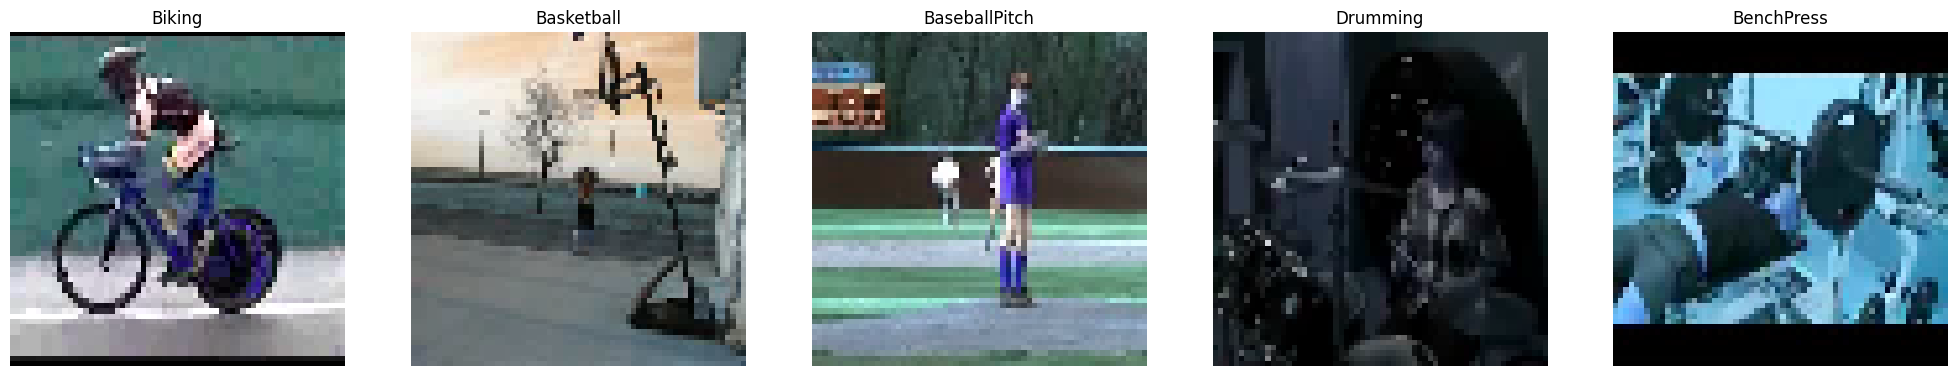

In [22]:
import matplotlib.pyplot as plt

# Random testing the training dataset
plt.figure(figsize=(25, 5))
train_iter = iter(train_ds)

for i in range(5):
    rand_test = next(train_iter)
    plt.subplot(1, 5, i + 1)
    plt.imshow(rand_test[0][0, 0, :, :, :])  # Access the first frame in the sequence
    plt.title(CLASSES_LIST[rand_test[1][0].numpy().argmax()])
    plt.axis(False)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the ConvLSTM Approach</font>**

In this step, I will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation. 


### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**


To construct the model, I will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category. 

I will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [23]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # I will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH,
                                                                                     IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=False))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [24]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 8)     3200      
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 8)    0         
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 31, 31, 8)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 16)    13888     
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 15, 15, 16)   0         
 tributed)                                                       
                                                        

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


Now I will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

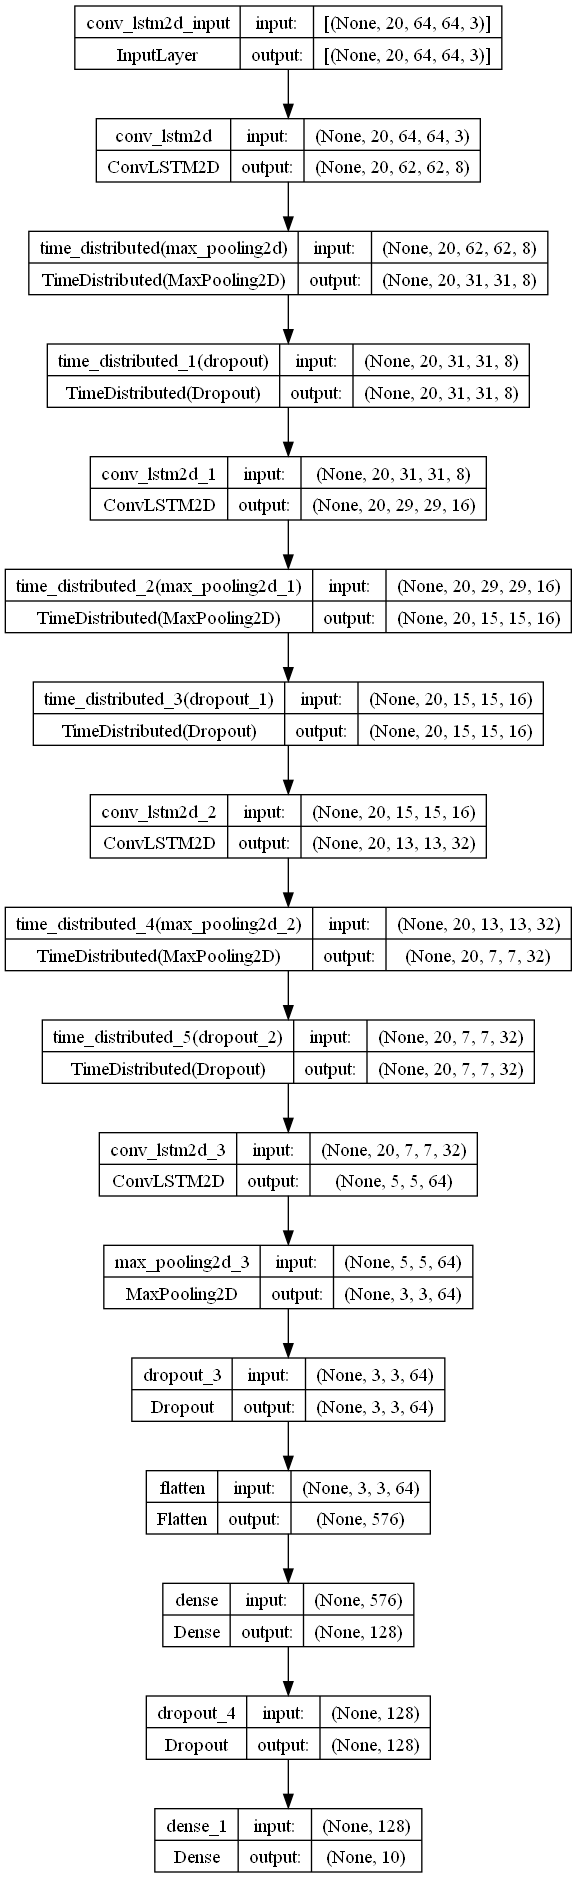

In [25]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**

Next, I will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [26]:
# creating tensorboard and early stopping callbacks
def create_tensorboard_callback(dir_name: str, exp_name: str):
    log_dir = os.path.join(dir_name, exp_name, dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
    log_dir = log_dir.replace("\\", "/")  # Replace backslashes with forward slashes
    os.makedirs(log_dir, exist_ok=True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'[INFO] Saving Tensorboard log files to: {log_dir}')
    return tensorboard_callback


early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=30,
                                        mode='min',
                                        verbose=1,
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                       mode='min',
                                       factor=0.2,
                                       patience=20,
                                       verbose=1,
                                       min_lr=1e-7)

In [27]:
# Compiling the model
convlstm_model.compile(loss='categorical_crossentropy', 
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# Fitting the model
start_time = time.time()
convlstm_model_training_history = convlstm_model.fit(train_ds,
                                     epochs=400,
                                     steps_per_epoch=len(train_ds),
                                     validation_data=test_ds,
                                     validation_steps=len(test_ds),
                                     callbacks=[create_tensorboard_callback(dir_name='training_logs', exp_name='convlstm_model'),
                                                early_stopping_callback,
                                                reduce_lr_callback])
end_time = time.time()
training_time = end_time - start_time

# Print the best epoch
best_epoch = early_stopping_callback.best_epoch
print(f"\n[INFO] Best epoch: {best_epoch}")

print(f'\n[INFO] Total time taken to train the convlstm_model with early stopping:\nTotal Epochs: {len(convlstm_model_training_history.history["loss"])}\nTotal Training Time: {training_time:.2f} sec.')

[INFO] Saving Tensorboard log files to: training_logs/convlstm_model/2023-06-05-12-00-57
Epoch 1/400
41/41 [==============================] - 58s 620ms/step - loss: 2.0772 - accuracy: 0.2630 - val_loss: 1.6623 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 2/400
41/41 [==============================] - 24s 584ms/step - loss: 1.4298 - accuracy: 0.5000 - val_loss: 1.1158 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 3/400
41/41 [==============================] - 23s 572ms/step - loss: 1.1411 - accuracy: 0.5951 - val_loss: 1.0242 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 4/400
41/41 [==============================] - 23s 572ms/step - loss: 0.9059 - accuracy: 0.6802 - val_loss: 1.0178 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 5/400
41/41 [==============================] - 24s 577ms/step - loss: 0.7942 - accuracy: 0.7185 - val_loss: 0.7781 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 6/400
41/41 [==============================] - 24s 590ms/step - loss: 0.6582 - accuracy: 0.7605 - val_loss: 1.1709 - val

In [28]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

# Generate class probabilities from your model
y_pred = convlstm_model.predict(features_test)

# Convert probabilities into class labels
y_pred_binary = np.argmax(y_pred, axis=1)

# Converting the binary predictions to multilabel format.
lb = LabelBinarizer()
lb.fit(labels_test) # You can fit the LabelBinarizer on the true labels.
y_pred_multilabel = lb.transform(y_pred_binary)

# Now calculate the precision score
precision = precision_score(labels_test, y_pred_multilabel, average='weighted')
print('Precision:', precision)

9/9 [==============================] - 2s 99ms/step
Precision: 0.8768983236408916


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now I will save the model to avoid training it from scratch every time we need the model.

In [29]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**


Now I will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [30]:
def plot_model_curves(history, best_epoch: int=None):
    """
    Plots separate loss and accuracy curves for training and validation metrics.
    
    Parameters:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
        best_epoch: int(default: None), A integer for indicating the best epoch received during the model training by the early stopping callback.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(15, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

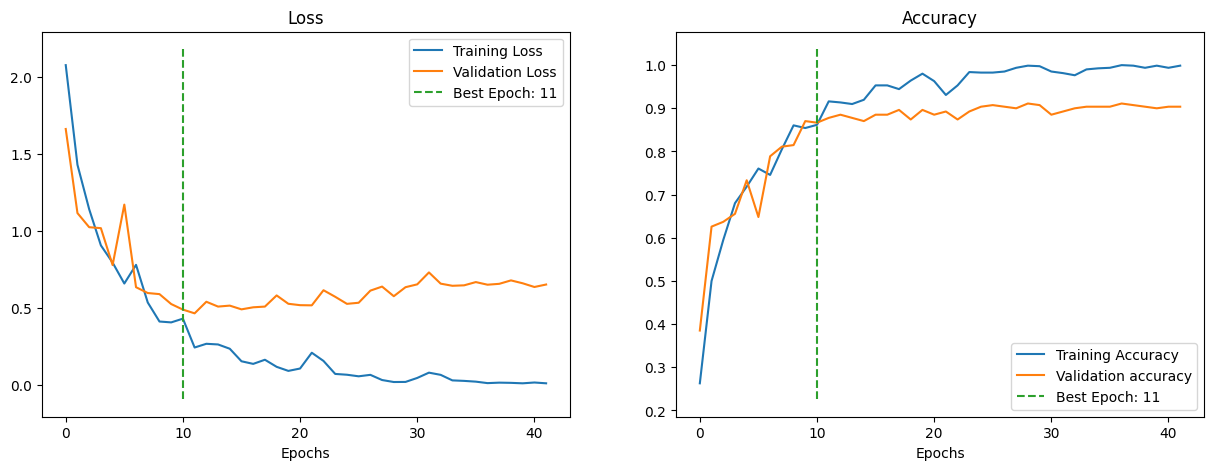

In [31]:
plot_model_curves(history=convlstm_model_training_history, best_epoch=best_epoch)

9/9 [==============================] - 1s 98ms/step


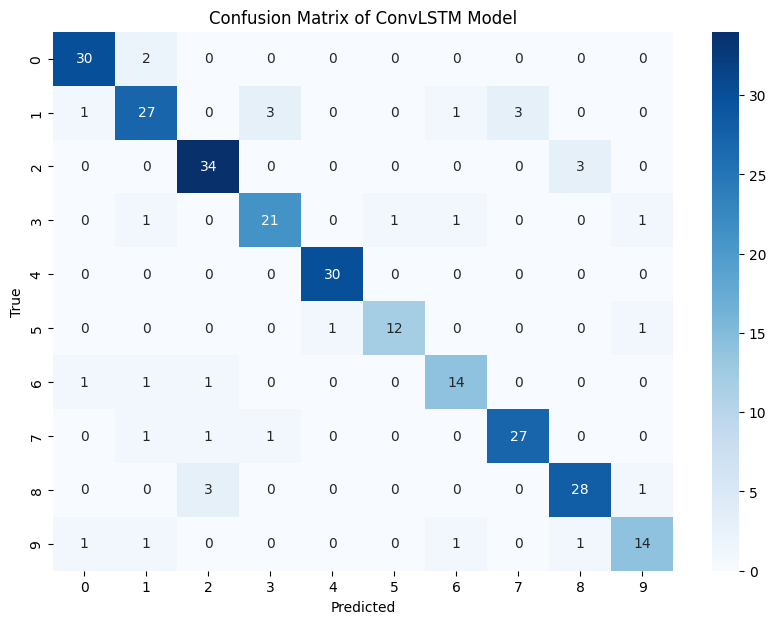

In [32]:
# Get the predicted labels for the test dataset
y_pred = convlstm_model.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test dataset
y_true = np.argmax(labels_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of ConvLSTM Model')
plt.show()

## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

In this step, I will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, I will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, I will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [33]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # I will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now I will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [34]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 20, 64, 64, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 64, 64, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 32, 32, 64)  

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now I will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

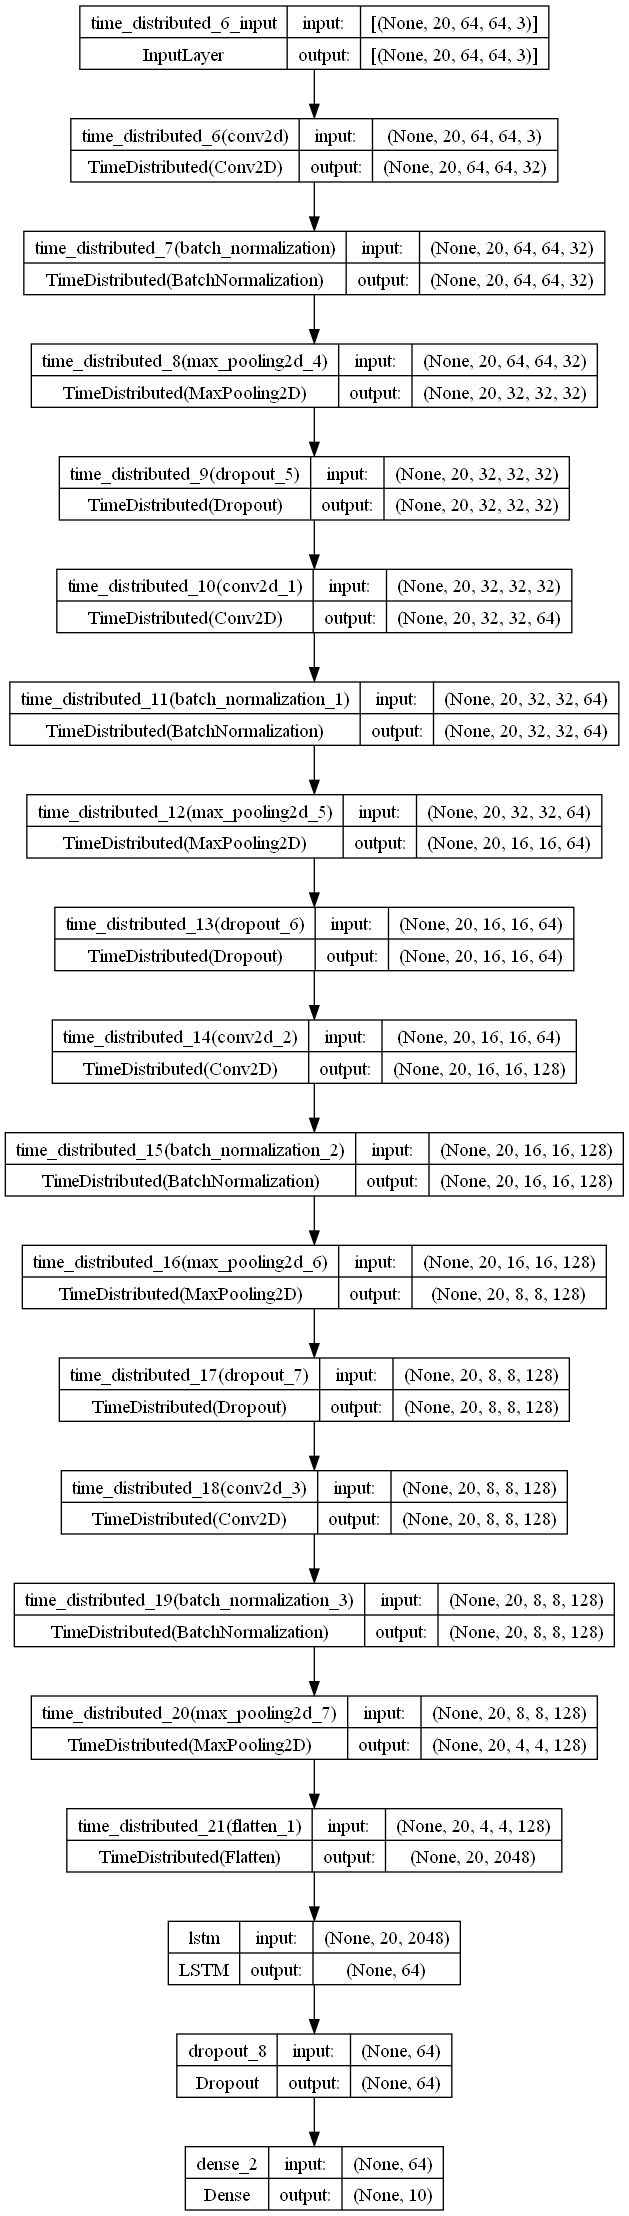

In [36]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, I will compile and start training the model.

In [37]:
# creating tensorboard and early stopping callbacks
def create_tensorboard_callback(dir_name: str, exp_name: str):
    log_dir = os.path.join(dir_name, exp_name, dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
    log_dir = log_dir.replace("\\", "/")  # Replace backslashes with forward slashes
    os.makedirs(log_dir, exist_ok=True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'[INFO] Saving Tensorboard log files to: {log_dir}')
    return tensorboard_callback


early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=30,
                                        mode='min',
                                        verbose=1,
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                       mode='min',
                                       factor=0.2,
                                       patience=20,
                                       verbose=1,
                                       min_lr=1e-7)

In [38]:
# Compiling the model
LRCN_model.compile(loss='categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Fitting the model
start_time = time.time()
LRCN_model_training_history = LRCN_model.fit(train_ds,
                                 epochs=400,
                                 steps_per_epoch=len(train_ds),
                                 validation_data=test_ds,
                                 validation_steps=len(test_ds),
                                 callbacks=[create_tensorboard_callback(dir_name='training_logs', exp_name='LRCN_model'),
                                            early_stopping_callback,
                                            reduce_lr_callback])
 
end_time = time.time()
training_time = end_time - start_time 

# Print the best epoch
best_epoch = early_stopping_callback.best_epoch
print(f"\n[INFO] Best epoch: {best_epoch}")

print(f'\n[INFO] Total time taken to train the lrcn_model2 with early stopping:\nTotal Epochs: {len(LRCN_model_training_history.history["loss"])}\nTotal Training Time: {training_time:.2f} sec.')


[INFO] Saving Tensorboard log files to: training_logs/LRCN_model/2023-06-05-12-18-07
Epoch 1/400
41/41 [==============================] - 11s 88ms/step - loss: 1.8832 - accuracy: 0.3309 - val_loss: 2.4588 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/400
41/41 [==============================] - 2s 56ms/step - loss: 1.3519 - accuracy: 0.5321 - val_loss: 2.6418 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/400
41/41 [==============================] - 2s 56ms/step - loss: 1.2813 - accuracy: 0.5827 - val_loss: 2.3025 - val_accuracy: 0.1407 - lr: 0.0010
Epoch 4/400
41/41 [==============================] - 2s 56ms/step - loss: 1.0784 - accuracy: 0.6556 - val_loss: 2.4507 - val_accuracy: 0.2037 - lr: 0.0010
Epoch 5/400
41/41 [==============================] - 2s 56ms/step - loss: 0.9161 - accuracy: 0.7148 - val_loss: 2.3030 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 6/400
41/41 [==============================] - 2s 56ms/step - loss: 0.7783 - accuracy: 0.7679 - val_loss: 2.4696 - val_accuracy: 0.22

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, I will evaluate the `LRCN` model on the test set.

In [39]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

# Generate class probabilities from your model
y_pred = LRCN_model.predict(features_test)

# Convert probabilities into class labels
y_pred_binary = np.argmax(y_pred, axis=1)

# Converting the binary predictions to multilabel format.
lb = LabelBinarizer()
lb.fit(labels_test) # You can fit the LabelBinarizer on the true labels.
y_pred_multilabel = lb.transform(y_pred_binary)

# Now calculate the precision score
precision = precision_score(labels_test, y_pred_multilabel, average='weighted')
print('Precision:', precision)

9/9 [==============================] - 1s 17ms/step
Precision: 0.9688300671428566


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, I will save the model for future uses using the same technique we had used for the previous model.

In [40]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now I will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


In [41]:
def plot_model_curves(history, best_epoch: int=None):
    """
    Plots separate loss and accuracy curves for training and validation metrics.
    
    Parameters:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
        best_epoch: int(default: None), A integer for indicating the best epoch received during the model training by the early stopping callback.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(15, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

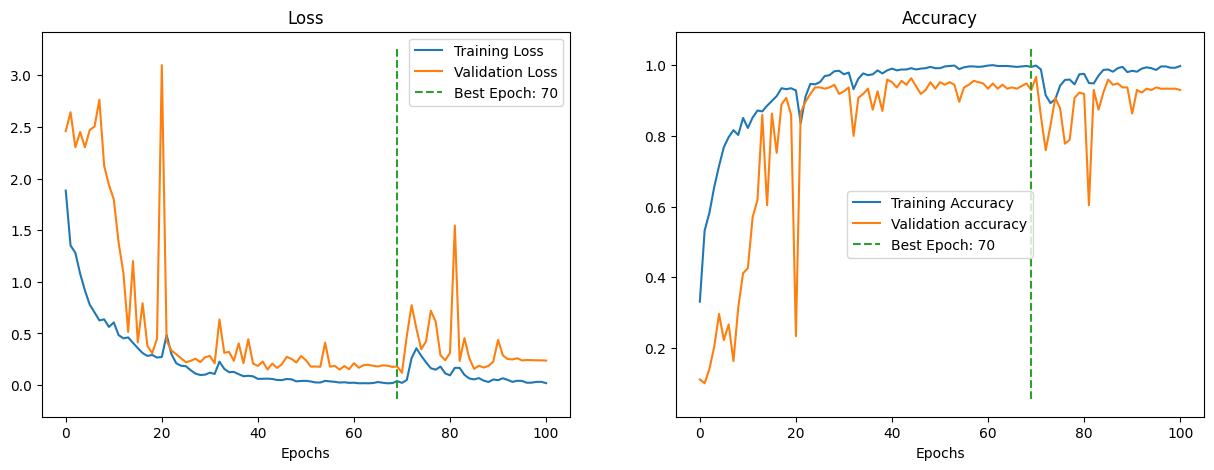

In [42]:
plot_model_curves(history=LRCN_model_training_history, best_epoch=best_epoch)

9/9 [==============================] - 0s 17ms/step


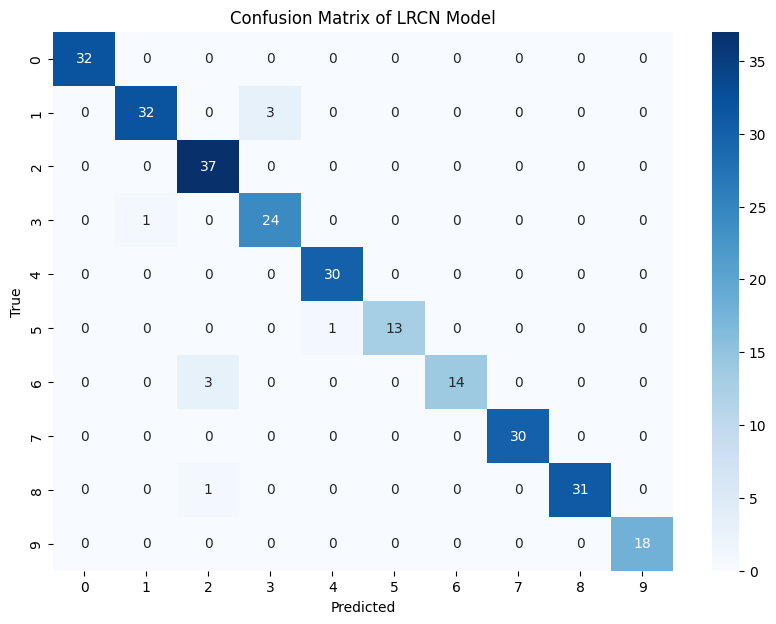

In [43]:
# Get the predicted labels for the test dataset
y_pred = LRCN_model.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test dataset
y_true = np.argmax(labels_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of LRCN Model')
plt.show()

## **<font style="color:rgb(134,19,348)">Step 6: Test the Best Performing Model on YouTube videos</font>**

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, I will put the `LRCN` model to test on some youtube videos. 

### **<font style="color:rgb(134,19,348)">Create a Function to Download YouTube Videos:</font>**

I will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [44]:
def download_yt_videos(yt_url_list: list, save_dir: str):
    """
    Download YouTube videos using this helper function.
    
    Parameters:
        yt_url_list: list, A list containing the URLs of the YouTube videos.
        save_dir: str, A string specifying the name of the directory in which the 
                       videos should be saved.
    Returns:
        file_path_list: list, A list containing the file paths of the downloaded videos.
    """
    # Creating an empty list to store downloaded file paths.
    file_path_list = []
    
    for url in yt_url_list:
        video = YouTube(url=url)
        
        # Getting the title and the video URL
        title = video.title
        video_url = video.streaming_data.get('formats')[-1]['url']
        
        # Removing invalid characters from the title
        invalid_chars = r'\/:*?"<>|'
        for char in invalid_chars:
            title = title.replace(char, '')
        
        # Checking the save directory
        if not os.path.exists(save_dir):
            print('[INFO] Creating an output directory to store the videos.\n')
            os.makedirs(save_dir, exist_ok=True)
        
        # Downloading and saving to the directory
        file_path = f'{save_dir}/{title}.mp4'
        file_path_list.append(file_path)
        urlretrieve(video_url, file_path)
        print(f"[INFO] Video '{title}' has been downloaded and saved as: '{file_path}'")
    
    return file_path_list


### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

Now I will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [45]:
# Downloading YouTube videos
testing_data_list = download_yt_videos(yt_url_list=['https://youtu.be/8rzPugzAf68',
                                                    'https://youtu.be/vxGgYSRGdSA',
                                                    'https://youtu.be/WuSg920GYnM',
                                                    'https://youtu.be/Ve-8m5-gucs',
                                                    'https://www.youtube.com/shorts/c_U5g6UaG8E',
                                                    'https://youtu.be/nDsNt2bQjww'], 
                                       save_dir='test_data')

[INFO] Creating an output directory to store the videos.

[INFO] Video 'v BaseballPitch g02 c02' has been downloaded and saved as: 'test_data/v BaseballPitch g02 c02.mp4'
[INFO] Video 'v Basketball g03 c03' has been downloaded and saved as: 'test_data/v Basketball g03 c03.mp4'
[INFO] Video 'v Kayaking g06 c05' has been downloaded and saved as: 'test_data/v Kayaking g06 c05.mp4'
[INFO] Video 'v WalkingWithDog g03 c02' has been downloaded and saved as: 'test_data/v WalkingWithDog g03 c02.mp4'
[INFO] Video 'Mike tyson The Beast of Boxing 🥊 😱One Punch Man🥊💪' has been downloaded and saved as: 'test_data/Mike tyson The Beast of Boxing 🥊 😱One Punch Man🥊💪.mp4'
[INFO] Video 'video_1' has been downloaded and saved as: 'test_data/video_1.mp4'


### **<font style="color:rgb(134,19,348)">Create a Function To Perform a Single Prediction on Videos</font>**


Now let's create a function that will perform a single prediction for the complete videos. I will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.  

In [46]:
def predict_class_video(video_file_path: str, sequence_length: int=20):
    """
    Predict Video class using the LRCN Model and prints the predicted class and the probability score.
    
    Parameters:
        video_file_path: str, file path od the video in string format.
        sequence_length: int(default: 20), the timesteps number used for training the model.
    """
    # Reading the video file
    video_reader = cv2.VideoCapture(video_file_path)
    
    # Extracting frames at certain interval for max sequence length.
    frames_list = []
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames = max(int(total_frames/sequence_length), 1)
    
    # Looping and extracting
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames)
        success, frame = video_reader.read()
        if not success:
            break
        resize_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        norm_frame = resize_frame/255.
        frames_list.append(norm_frame.astype('float32'))
    
    # predicting using the LRCN model 
    pred_prob = LRCN_model.predict(np.expand_dims(frames_list, axis=0))[0]
    pred_label = np.argmax(pred_prob)
    pred_class = CLASSES_LIST[pred_label]
    
    # printing the result
    print(f'[INfO] Action Predicted: {pred_class}')
    print(f'[INFO] Prediction Probalities: {pred_prob[pred_label]:.2f}\n')
    video_reader.release()

### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**

Now I will utilize the function **`predict_single_action()`** created above to perform a single prediction on a complete youtube test video that I will download using the function **`download_youtube_videos()`**, we had created above.

In [47]:
# Change the index(range 0-4) to predict different files.
video_path = testing_data_list[0]

# predicting and visualizing the video
print(f'File: {video_path}')
predict_class_video(video_file_path=video_path, sequence_length=SEQUENCE_LENGTH)
Video(video_path, width=500)

File: test_data/v BaseballPitch g02 c02.mp4
1/1 [==============================] - 0s 81ms/step
[INfO] Action Predicted: BaseballPitch
[INFO] Prediction Probalities: 1.00



# Multiple Prediction on Videos

I will now create a function that will read the downloaded video file and predict the classes in the video, after that the function will save the video file with the result.



In [48]:
# Downloading a youtube videos
testing_data_list2 = download_yt_videos(yt_url_list=['https://youtu.be/PlIQWY-ByWk',], save_dir='test_data')

[INFO] Video 'CompiledVideo_10' has been downloaded and saved as: 'test_data/CompiledVideo_10.mp4'


In [49]:
def predict_save_video(video_file_path: str, result_file_name: str, sequence_length: int=20):
    """
    Predict Video class for every timesteps using the LRCN Model and return the result class in the video.
    
    Parameters:
        video_file_path: str, file path od the video in string format.
        result_file_name: str, file name to store the final video.
        sequence_length: int(default: 20), the timesteps number used for training the model.
    """
    video_reader = cv2.VideoCapture(video_file_path)
    org_vid_ht = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    org_vid_wd = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

    video_writer = cv2.VideoWriter(result_file_name, 
                                   cv2.VideoWriter_fourcc('V', 'P', '0', '9'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (org_vid_wd, org_vid_ht))
    
    frame_queue = deque(maxlen=sequence_length)
    pred_class = ''
    while video_reader.isOpened():
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        norm_frame = resized_frame/255.
        frame_queue.append(norm_frame.astype('float32'))
        if len(frame_queue) == sequence_length:
            pred_prob = LRCN_model.predict(np.expand_dims(frame_queue, axis=0), verbose=0)[0]
            pred_label = np.argmax(pred_prob)
            pred_class = CLASSES_LIST[pred_label]
        frame_cpy = frame.copy()
        cv2.rectangle(frame, (0, int(org_vid_ht-50)), (org_vid_wd, org_vid_ht), (0,0,0), cv2.FILLED)
        text_size = cv2.getTextSize(pred_class, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_x = int((org_vid_wd - text_size[0]) / 2)
        text_y = int(org_vid_ht - 15)
        cv2.putText(frame, pred_class, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        frame_overlay = cv2.addWeighted(frame, 0.4, frame_cpy, 0.6, 0)
        video_writer.write(frame_overlay)
    video_reader.release()
    video_writer.release()

In [50]:
predict_save_video(testing_data_list2[0], 'video.mp4', sequence_length=SEQUENCE_LENGTH)
Video('video.mp4', width=500)